In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from pathlib import Path

In [2]:
input_path =  Path("data/raw/housing.csv")
df = pd.read_csv(input_path)
df_temp =  df.copy()

In [3]:
print('Number of  Examples = {}'.format(df.shape[0]))
print('X Shape = {}'.format(df.shape[1]))
print('Y Shape = {}\n'.format(df.shape[0]))
print(df.columns)

Number of  Examples = 19195
X Shape = 10
Y Shape = 19195

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19195 entries, 0 to 19194
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           19195 non-null  float64
 1   latitude            19195 non-null  float64
 2   housing_median_age  19195 non-null  float64
 3   total_rooms         19195 non-null  float64
 4   total_bedrooms      19006 non-null  float64
 5   population          19195 non-null  float64
 6   households          19195 non-null  float64
 7   median_income       19195 non-null  float64
 8   median_house_value  19195 non-null  float64
 9   ocean_proximity     19195 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.5+ MB
None


In [5]:
df.sample(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
1030,-121.57,39.80,23.0,790.0,137.0,365.0,152.0,2.1912,115200.0,INLAND
280,-122.19,37.77,45.0,1852.0,393.0,1132.0,349.0,2.7159,101400.0,NEAR BAY
18078,-121.03,37.69,5.0,4034.0,771.0,1967.0,742.0,3.8065,146000.0,INLAND


In [6]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
for col in df.columns.tolist():
    print('({}) column missing values: {}'.format(col, df[col].isnull().sum()))
print('\n')

(longitude) column missing values: 0
(latitude) column missing values: 0
(housing_median_age) column missing values: 0
(total_rooms) column missing values: 0
(total_bedrooms) column missing values: 189
(population) column missing values: 0
(households) column missing values: 0
(median_income) column missing values: 0
(median_house_value) column missing values: 0
(ocean_proximity) column missing values: 0




['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']
ISLAND have 2 values


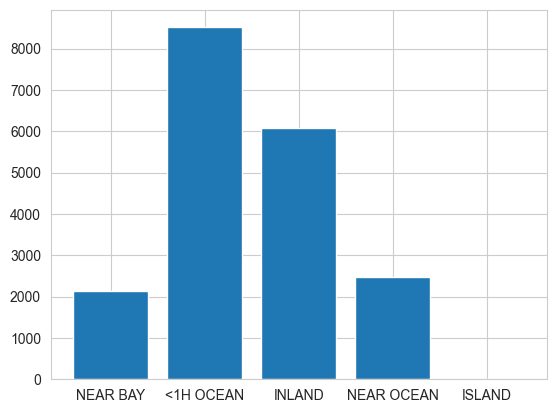

In [8]:
oceanProximity = df['ocean_proximity'].unique()
print(oceanProximity)

values = []
for level in oceanProximity:
    values.append(df['ocean_proximity'].loc[df['ocean_proximity'] == level].count())
plt.bar(oceanProximity, values)
print('ISLAND have {} values'.format( values[-1]))

Стало интересно посмотреть, как распределено количество недвижимости по категориям.

In [9]:
#df.ocean_proximity = df.ocean_proximity.map( {'NEAR BAY':1, '<1H OCEAN':2, 'INLAND':3, 'NEAR OCEAN':4, 'ISLAND':5} )
df.ocean_proximity = pd.Categorical(df.ocean_proximity)
df = df.assign(ocean_proximity_code=df.ocean_proximity.cat.codes)
oceanProximity = df['ocean_proximity'].unique()
print(oceanProximity)

['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND']
Categories (5, object): ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']


In [10]:
df_corr = df.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_corr[df_corr['Feature 1'] == 'total_bedrooms']

,Feature 1,Feature 2,Correlation Coefficient
6,total_bedrooms,total_bedrooms,1.000000
10,total_bedrooms,households,0.979298
12,total_bedrooms,total_rooms,0.930179
21,total_bedrooms,population,0.876248
28,total_bedrooms,housing_median_age,0.321010
64,total_bedrooms,longitude,0.068371
66,total_bedrooms,latitude,0.065190
72,total_bedrooms,median_house_value,0.047280
91,total_bedrooms,ocean_proximity_code,0.012700
94,total_bedrooms,median_income,0.010443


Из таблицы видно, что параметр total_bedrooms сиьно коррелирует с параметром households: 98%, почти линейная зависимость. Тогда заменим недостающие значения с помощью интерполяции. Для этого отсортируем строки по households и проведем линейную интерполяцию на значениях total_bedrooms.

In [11]:
df[df['total_bedrooms'].isnull()]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_code
260,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY,3
306,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY,3
494,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY,3
517,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY,3
682,-122.14,37.67,37.0,3342.0,NaN,1635.0,557.0,4.7933,186900.0,NEAR BAY,3
...,...,...,...,...,...,...,...,...,...,...,...
18715,-118.80,34.41,45.0,1610.0,NaN,1148.0,347.0,2.7000,120400.0,<1H OCEAN,0
18845,-119.18,34.19,19.0,2393.0,NaN,1938.0,762.0,1.6953,167400.0,NEAR OCEAN,4
18945,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0,<1H OCEAN,0
19024,-118.75,34.29,17.0,5512.0,NaN,2734.0,814.0,6.6073,258100.0,<1H OCEAN,0


In [12]:
df = df.sort_values(by=['households'])

In [13]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_code
15012,-122.50,37.79,52.0,8.0,1.0,13.0,1.0,15.0001,500001.0,NEAR BAY,3
2324,-119.54,36.51,36.0,49.0,7.0,28.0,2.0,4.6250,162500.0,INLAND,1
2905,-117.79,35.21,4.0,2.0,2.0,6.0,2.0,2.3750,137500.0,INLAND,1
11410,-116.95,33.86,1.0,6.0,2.0,8.0,2.0,1.6250,55000.0,INLAND,1
11571,-114.62,33.62,26.0,18.0,3.0,5.0,3.0,0.5360,275000.0,INLAND,1
...,...,...,...,...,...,...,...,...,...,...,...
8335,-118.44,33.98,21.0,18132.0,5419.0,7431.0,4930.0,5.3359,500001.0,<1H OCEAN,0
5634,-117.78,34.03,8.0,32054.0,5290.0,15507.0,5050.0,6.0191,253900.0,<1H OCEAN,0
9571,-117.74,33.89,4.0,37937.0,5471.0,16122.0,5189.0,7.4947,366300.0,<1H OCEAN,0
12203,-121.44,38.43,3.0,39320.0,6210.0,16305.0,5358.0,4.9516,153700.0,INLAND,1


In [14]:
df['total_bedrooms']= df['total_bedrooms'].interpolate()
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_code
15012,-122.50,37.79,52.0,8.0,1.0,13.0,1.0,15.0001,500001.0,NEAR BAY,3
2324,-119.54,36.51,36.0,49.0,7.0,28.0,2.0,4.6250,162500.0,INLAND,1
2905,-117.79,35.21,4.0,2.0,2.0,6.0,2.0,2.3750,137500.0,INLAND,1
11410,-116.95,33.86,1.0,6.0,2.0,8.0,2.0,1.6250,55000.0,INLAND,1
11571,-114.62,33.62,26.0,18.0,3.0,5.0,3.0,0.5360,275000.0,INLAND,1
...,...,...,...,...,...,...,...,...,...,...,...
8335,-118.44,33.98,21.0,18132.0,5419.0,7431.0,4930.0,5.3359,500001.0,<1H OCEAN,0
5634,-117.78,34.03,8.0,32054.0,5290.0,15507.0,5050.0,6.0191,253900.0,<1H OCEAN,0
9571,-117.74,33.89,4.0,37937.0,5471.0,16122.0,5189.0,7.4947,366300.0,<1H OCEAN,0
12203,-121.44,38.43,3.0,39320.0,6210.0,16305.0,5358.0,4.9516,153700.0,INLAND,1


In [15]:
df[df['total_bedrooms'].isnull()]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_code


In [16]:
df = df.sort_index(ascending=True)
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_code
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,3
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,3
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,3
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3
...,...,...,...,...,...,...,...,...,...,...,...
19190,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,1
19191,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,1
19192,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,1
19193,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,1


In [17]:
df_corr_MHV = df.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_corr_MHV.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_corr_MHV[df_corr_MHV['Feature 1'] == 'median_house_value']

,Feature 1,Feature 2,Correlation Coefficient
2,median_house_value,median_house_value,1.000000
25,median_house_value,median_income,0.688830
40,median_house_value,latitude,0.144646
42,median_house_value,total_rooms,0.132531
52,median_house_value,housing_median_age,0.106521
59,median_house_value,ocean_proximity_code,0.081156
69,median_house_value,households,0.063839
73,median_house_value,total_bedrooms,0.048372
75,median_house_value,longitude,0.045601
81,median_house_value,population,0.027498


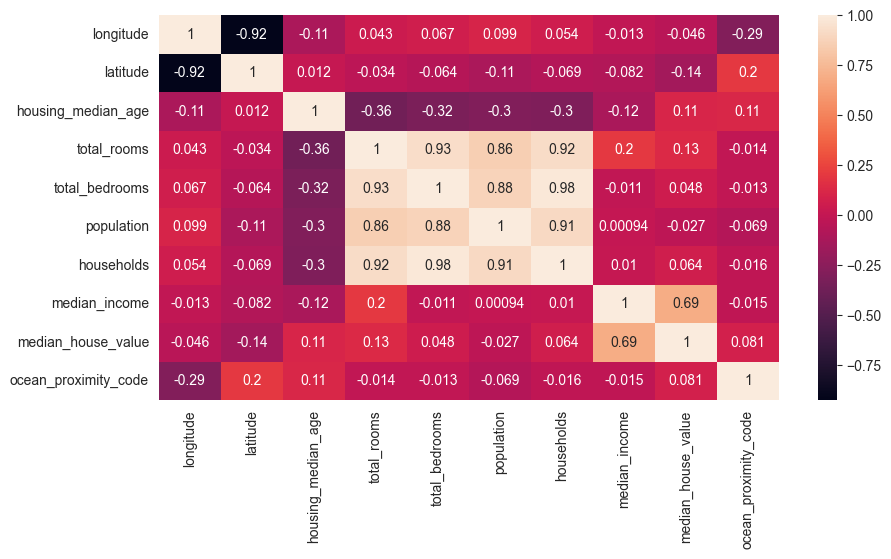

In [18]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.heatmap(corr, annot=True)
plt.show()

Наиболее кореллируемыми с median_house_value параметрами являются median_income, latitude и total_rooms. Эти параметры точно остаются в модели.
Корелляция с параметром total_bedrooms невысокая. При этом total_bedrooms состоит не только из реальных данных, но также содержит в себе восстановленные интерполяцией значения. А еще total_bedrooms сильно кореллирует с параметром households, который показывает лучшую связь с итоговой величиной. Поэтому для первого приближения можно убрать колонку total_bedrooms из модели.

<AxesSubplot:xlabel='ocean_proximity'>

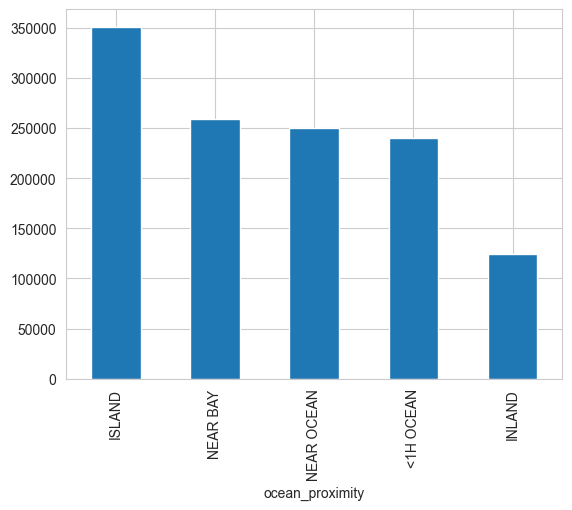

In [19]:
mean_MHV_ocean = df.groupby('ocean_proximity')['median_house_value'].mean().sort_values(ascending=False)
mean_MHV_ocean.plot(kind='bar')

По графику видно, что средние значения параметра median_house_value для категорий 'NEAR BAY', 'NEAR OCEAN', '<1H OCEAN' находятся примерно на одном уровне, так что эти категории можно объединить в одну 'NEAR OCEAN'.

Вывод:
По итогам анализа можно для первой итерации избавиться от параметра total_bedrooms, который был частично восстановлен, но все же оказался слабокоррелируемым с итоговой величиной. Также стоит сгруппировать часть категорий параметра ocean_proximity.